# Connectivity Analysis Pipeline

This notebook is a first shot at making a connectivity analysis pipeline using **EBRAINS** atlas services through **siibra**, and **nilearn**. 

The pipeline will ideally contains the following steps:

- **Step 1:** <a href='#Step1'>Load fmri data from EBRAINS</a>
- **Step 2:** <a href='#Step2'>Load a parcellation from EBRAINS human brain atlas using the `siibra` client</a>
- **Step 3:** <a href='#Step3'>Use nilearn to extract signals</a>
- **Step 4:** <a href='#Step4'>Use nilearn to compute some connectivity from these signals</a>
- **Step 5:** <a href='#Step5'>Use nilearn to visualize this connectivity (as a matrix, as a graph...)</a>
- **Step 6:** <a href='#Step6'>Upload the results back to EBRAINS</a>
- **Step 7:** Visualize them using the visualization tools of EBRAINS

## Step 1: Load fmri data

Ideally this will be loaded from **EBRAINS**. 

**TODOS:**

- [ ] find and upload good datasets
- [ ] find a way to fetch them easily 

For now, we rely on **Nilearn** for this.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't have Nilearn installed, you can get it with pip:

$ pip install nilearn
</div>

In [1]:
# Do not display warnings to prettify the notebook...
import warnings
warnings.simplefilter("ignore")

In [2]:
# import nilearn newest version (make sure it is 0.8.0 or more)
import nilearn
nilearn.__version__

'0.8.0'

We load 10 development fmri data for 10 subjects:

In [3]:
from nilearn.datasets import fetch_development_fmri

# Ten subjects of brain development fmri data
data = fetch_development_fmri(n_subjects=10)

## Step 2: Load an atlas from EBRAINS

We rely on the `siibra` library to work with EBRAINS human brain atlas and access the *Julich-Brain Probabilistic Cytoarchitectonic Maps (v2.5)*.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't have siibra installed, you can get it with pip:

$ pip install siibra
</div>

<div class="alert alert-block alert-danger">
<b>Warning:</b> <p>If this is the first time you use siibra, you will have to provide an authentication token (see <a href="https://siibra-python.readthedocs.io/en/latest/authentication.html">the siibra documentation on authenticating to EBRAINS</a>).</p>
</div>

Get the authentication token:

**NOTE: The authentication point isn't working at the moment.**

In [5]:
import webbrowser
webbrowser.open('https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize')
token = input("Enter your token here: ")

Enter your token here:  dd


Provide the token:

In [5]:
from os import environ
environ['HBP_AUTH_TOKEN'] = token

### 2.1 Fetch a parcellation object via siibra

In [4]:
import siibra
print(siibra.__version__)
siibra.logger.setLevel("INFO") # we want to see some messages
atlas = siibra.atlases.MULTILEVEL_HUMAN_ATLAS

[siibra:INFO]  Version: 0.1a8
[siibra:WARNING]  This is a development release. Use at your own risk. Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for spaces
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for parcellations
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for atlases


0.1a8


Select a parcellation among the possible choices:

In [5]:
atlas.parcellations

[Julich-Brain Cytoarchitectonic Maps 2.9,
 Julich-Brain Cytoarchitectonic Maps 2.5,
 Julich-Brain Cytoarchitectonic Maps 1.18,
 Short Fiber Bundles - HCP,
 Long White Matter Bundles,
 Superficial Fibre Bundles,
 BigBrain Isocortex,
 BigBrain Cortical Layers,
 DiFuMo 64,
 DiFuMo 128,
 DiFuMo 256,
 DiFuMo 512,
 DiFuMo 1024,
 Desikan-Killiany 2006,
 VEP Atlas]

**NOTE: I cannot find the same maps I was using before with left and right in the 4th dimension. Are they still supported?**

In [6]:
parcellation = "Julich-Brain Cytoarchitectonic Maps 2.5"
atlas.select_parcellation(parcellation)
assert atlas.selected_parcellation == parcellation

[siibra:INFO]  Select "Julich-Brain Cytoarchitectonic Maps 2.5"


In [7]:
atlas.selected_parcellation.description

'This dataset contains the whole-brain parcellation of the Julich-Brain Cytoarchitectonic Atlas in the MNI Colin 27 as well as the MNI ICBM 152 2009c nonlinear asymmetric reference space (Evans et al., 2012). The parcellation is derived from the individual probability maps (PMs) of the cytoarchitectonic regions released in the Julich-Brain Cytoarchitectonic Atlas, that are further combined into a Maximum Probability Map (MPM). The MPM is calculated by considering for each voxel the probability of all cytoarchitectonic areas released in the atlas, and determining the most probable assignment (Eickhoff 2005). Gap maps complement cortical maps to achieve full cortical coverage.'

### 2.2 Retrieve the parcellation map in MNI152 space

We load the map for this parcellation in MNI152 space. The map is a 4D image with integer values representing the labels of the parcellation. The fourth dimension splits the left and right hemisphere in this atlas **(not anymore? to be verified...)**. 

In [8]:
parcellation_map = atlas.get_map("mni152", maptype=siibra.MapType.LABELLED)
parcellation_map_niimg = parcellation_map.fetch()
parcellation_map_niimg.shape

(193, 229, 193)

### 2.3 Understand handling of region names and labels in siibra

The labels in the map correspond to the label list used in the parcellation object, except that the latter does not include the background label, 0:

In [9]:
import numpy as np
labels_seen = set(np.unique(parcellation_map_niimg.dataobj))
print("Labels in the label volume which are not defined by the parcellation object:")
print(labels_seen - atlas.regionlabels)

Labels in the label volume which are not defined by the parcellation object:
{0}


Interpreting index labels and region names in the parcellation map is fairly simple: Label indices and names can be decoded into region objects by the atlas:

In [10]:
# Ex: decode region for label 1
atlas.decode_region(1)

Area OP1 (POperc)
├── Area OP1 (POperc) left
└── Area OP1 (POperc) right

In [11]:
# Ex:decode region for name Fp1
print("Decoding the name 'Fp1'")
region = atlas.decode_region("Fp1")
print(repr(region))
print(f"This region has a name {region.name}")
print(f"This region has label {region.labels}.")

Decoding the name 'Fp1'
Area Fp1 (FPole)
├── Area Fp1 (FPole) left
└── Area Fp1 (FPole) right
This region has a name Area Fp1 (FPole)
This region has label {107}.


We can apply this to all labels and get a list of labels and matching names:

In [12]:
labels = list(atlas.regionlabels)
names = [atlas.decode_region(label).name for label in labels]
assert len(names) == len(labels)
assert len(names) == len(np.unique(parcellation_map_niimg.dataobj)) - 1 # Background is 0

## Step 3: Use Nilearn to extract signals from parcellation and functional data

In this section we use the nilearn `NiftiLabelsMasker` to extract the signals from the functional dataset and parcellation.

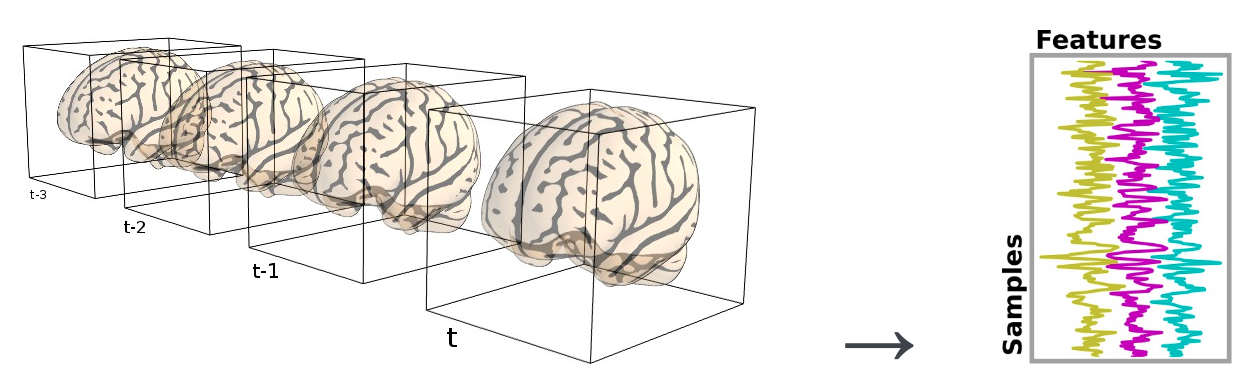

In [13]:
from IPython.display import Image
Image(filename='masker.png') 

*copyright - Image taken from the nilearn documentation.*

More information on maskers can be found in the <a href="https://nilearn.github.io/manipulating_images/masker_objects.html">nilearn online documentation</a>.

In [14]:
from nilearn.input_data import NiftiLabelsMasker

# Use NiftiLabelsMasker to extract signals from regions
masker = NiftiLabelsMasker(labels_img=parcellation_map_niimg, 
                           standardize=True) # Standardize the signals
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, 
                                            confounds=confounds))
time_series = np.array(time_series)
time_series.shape

(10, 168, 124)

We have **124** standardized time series of length **168** per subject (**10** subjects were loaded). 

We can plot them if needed:

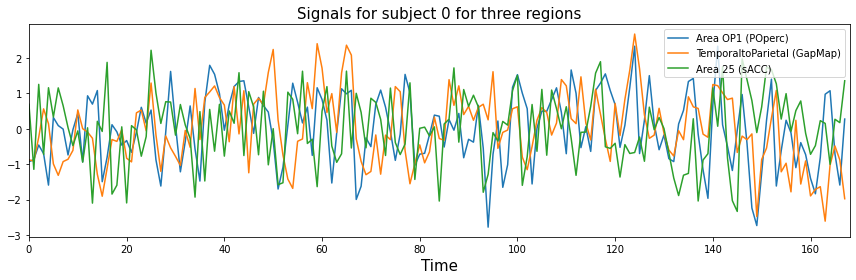

In [15]:
import matplotlib.pyplot as plt

subject_id = 0
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[subject_id, :, i], 
             label=names[i])
plt.legend()
plt.xlim((0, 168))
plt.xlabel("Time", fontsize=15)
plt.title(f"Signals for subject {subject_id} for three regions", fontsize=15)
plt.tight_layout()

## Step 4: Use Nilearn to compute a connectivity matrix

Here we compute the correlation between these time series:

In [16]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (10, 124, 124)

In order to visualize this matrix, we take the mean accross subject:

In [17]:
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (124, 124)

## Step 5: Use nilearn to visualize the connectivity

We can use **Nilearn** to visualize the connectivity, either as a matrix or as a graph:

### As a matrix

We can plot the matrix with the region names:

In [18]:
mean_correlation_matrix.shape, len(names)

((124, 124), 124)

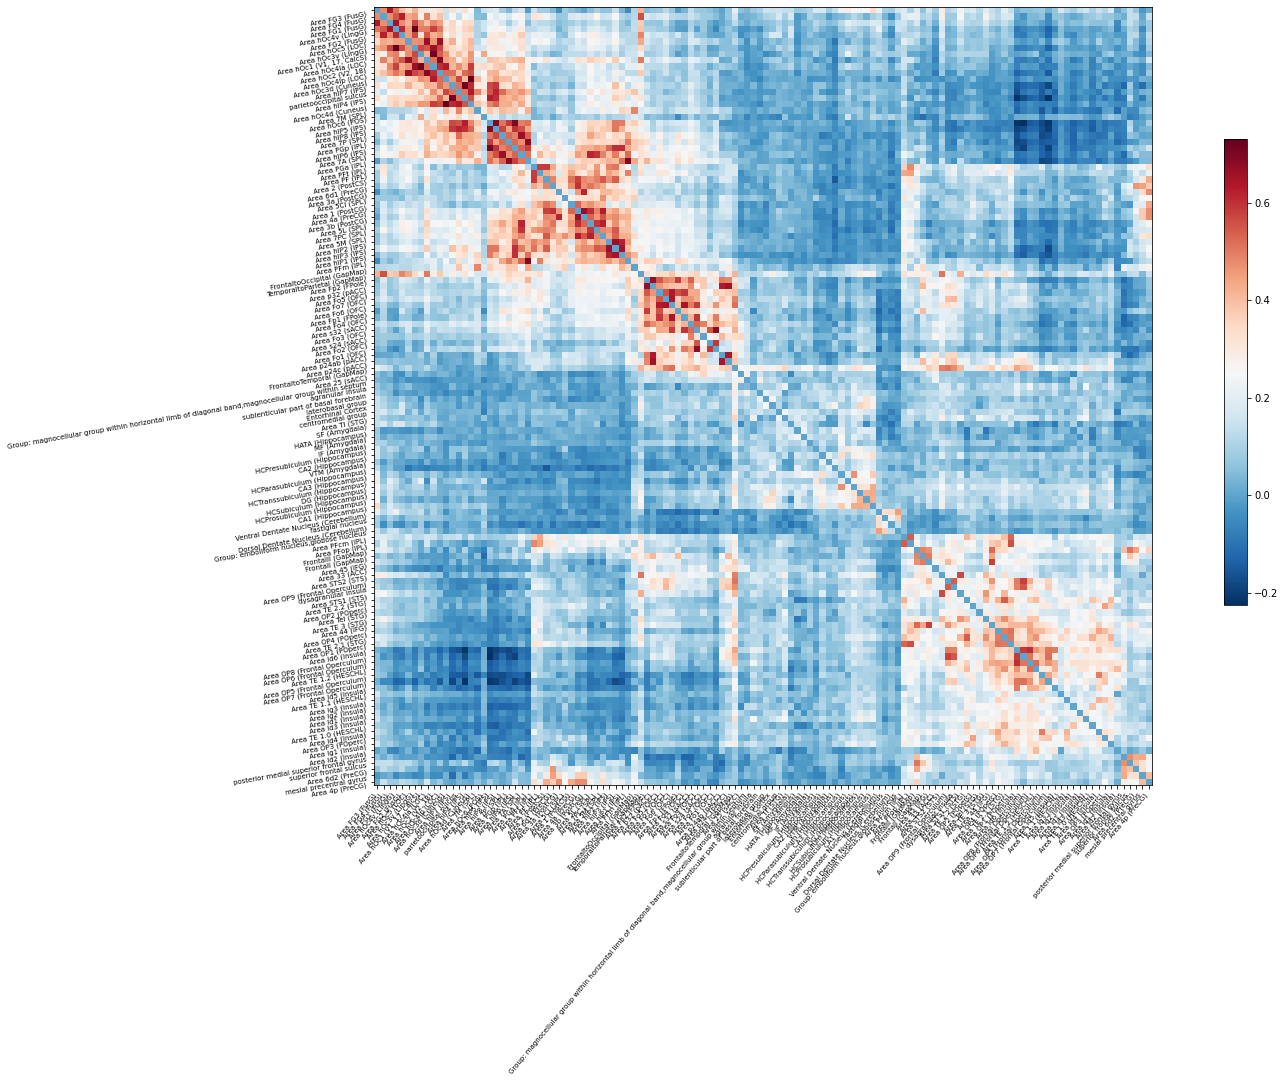

In [19]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
plot_matrix(mean_correlation_matrix, 
            figure=(16, 16), 
            labels=names, 
            reorder=True)

### As a graph

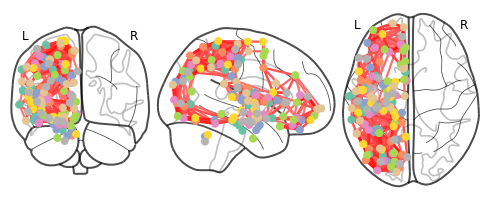

In [20]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
coordinates = find_parcellation_cut_coords(labels_img=parcellation_map_niimg)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

## Step 6: Upload the results back to ebrains

**TODOS:**

- Decide on a representation of the connectivity results
- Find how these results could be uploaded

In [21]:
from siibra.features.connectivity import ConnectivityMatrix

In [22]:
m = ConnectivityMatrix(parcellation_map_niimg, 
                       mean_correlation_matrix, 
                       names, 
                       None, None) # What are these?

In [23]:
m.parcellation